# 1. Dependencies

In [ ]:
# Install Dependencies
!pip install pandas sklearn numerapi

In [2]:
# Import Dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import numerapi
import time
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA, KernelPCA
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical

pd.set_option('chained_assignment', None)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# 2. Numerai Tournament API setup

In [ ]:
# Get your API keys and model_id from https://numer.ai/submit
public_id = "INSERT PUBLIC ID"
secret_key = "INSERT SECRET KEY"
model_id = "INSERT MODEL ID"
napi = numerapi.NumerAPI(public_id=public_id, secret_key=secret_key)

# 3. Download Data Sets

### Datasets 
*   `trainingData` is used to train the model
*   `tournamentData` is used to evaluate the model

### Column descriptions
*   id: a randomized id that corresponds to a stock 
*   era: a period of time
*   data_type: either `train`, `validation`, `test`, or `live` 
*   feature_*: abstract financial features of the stock 
*   target: abstract measure of stock performance


In [5]:
# Download Training Data From Numerai
start = time.time()
print(f"Downloading the lastest training data set. Current round is: {numerapi.NumerAPI(verbosity='info').get_current_round()}...\n")
trainingData = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz", header=0)
print(f"Training dataset has been loaded. It took {time.time() - start:0.2f} seconds")


Training dataset has been loaded. It took 35.08 seconds


In [7]:
# Download Tournament Data From Numerai
start_2 = time.time()
print(f"Downloading the lastest tournament data set. Current round is: {numerapi.NumerAPI(verbosity='info').get_current_round()}...\n")
tournamentData = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz", header=0)
print(f"Tournament dataset has been loaded. It took {time.time() - start_2:0.2f} seconds")


Tournament dataset has been loaded. It took 97.79 seconds


# 4. Explore The Dataset

In [8]:
# Print Training Data
trainingData.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [9]:
# Find Unique Items Within The Training Data
print(f'UNIQUE ERAS: {trainingData.era.unique()}\n')
print(f'UNIQUE DATA TYPE: {trainingData.data_type.unique()}')

UNIQUE ERAS: ['era1' 'era2' 'era3' 'era4' 'era5' 'era6' 'era7' 'era8' 'era9' 'era10'
 'era11' 'era12' 'era13' 'era14' 'era15' 'era16' 'era17' 'era18' 'era19'
 'era20' 'era21' 'era22' 'era23' 'era24' 'era25' 'era26' 'era27' 'era28'
 'era29' 'era30' 'era31' 'era32' 'era33' 'era34' 'era35' 'era36' 'era37'
 'era38' 'era39' 'era40' 'era41' 'era42' 'era43' 'era44' 'era45' 'era46'
 'era47' 'era48' 'era49' 'era50' 'era51' 'era52' 'era53' 'era54' 'era55'
 'era56' 'era57' 'era58' 'era59' 'era60' 'era61' 'era62' 'era63' 'era64'
 'era65' 'era66' 'era67' 'era68' 'era69' 'era70' 'era71' 'era72' 'era73'
 'era74' 'era75' 'era76' 'era77' 'era78' 'era79' 'era80' 'era81' 'era82'
 'era83' 'era84' 'era85' 'era86' 'era87' 'era88' 'era89' 'era90' 'era91'
 'era92' 'era93' 'era94' 'era95' 'era96' 'era97' 'era98' 'era99' 'era100'
 'era101' 'era102' 'era103' 'era104' 'era105' 'era106' 'era107' 'era108'
 'era109' 'era110' 'era111' 'era112' 'era113' 'era114' 'era115' 'era116'
 'era117' 'era118' 'era119' 'era120']


In [10]:
# Print Tournament Data
tournamentData.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,...,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,...,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,...,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75


In [11]:
# Find Unique Items Within Tournament Data
print(f'UNIQUE DATA TYPE: {tournamentData.data_type.unique()}\n')
print(f'UNIQUE ERAS: {tournamentData.era.unique()}')

UNIQUE DATA TYPE: ['validation' 'test' 'live']

UNIQUE ERAS: ['era121' 'era122' 'era123' 'era124' 'era125' 'era126' 'era127' 'era128'
 'era129' 'era130' 'era131' 'era132' 'era575' 'era576' 'era577' 'era578'
 'era579' 'era580' 'era581' 'era582' 'era583' 'era584' 'era585' 'era586'
 'era587' 'era588' 'era589' 'era590' 'era591' 'era592' 'era593' 'era594'
 'era595' 'era596' 'era597' 'era598' 'era599' 'era600' 'era601' 'era602'
 'era603' 'era604' 'era605' 'era606' 'era607' 'era608' 'era609' 'era610'
 'era611' 'era612' 'era613' 'era614' 'era615' 'era616' 'era617' 'era618'
 'era619' 'era620' 'era621' 'era622' 'era623' 'era624' 'era625' 'era626'
 'era627' 'era628' 'era629' 'era630' 'era631' 'era632' 'era633' 'era634'
 'era635' 'era636' 'era637' 'era638' 'era639' 'era640' 'era641' 'era642'
 'era643' 'era644' 'era645' 'era646' 'era647' 'era648' 'era649' 'era650'
 'era651' 'era652' 'era653' 'era654' 'era655' 'era656' 'era657' 'era658'
 'era659' 'era660' 'era661' 'era662' 'era663' 'era664' 'era665'

In [12]:
# Select Validation Data Out of Tournament Dataset
validationData = tournamentData[tournamentData.data_type=='validation']

# Select Test Data Out of Tournament Dataset
testData = tournamentData[tournamentData.data_type=='test']

# Select Live Data Out of Tournament Dataset
liveData = tournamentData[tournamentData.data_type=='live']

In [13]:
print(f"UNIQUE TRAINING TARGETS: {trainingData.target[trainingData.data_type=='train'].unique()}")
print(f"UNIQUE VALIDATION TARGETS: {tournamentData.target[tournamentData.data_type=='validation'].unique()}")
print(f"UNIQUE TEST TARGETS: {tournamentData.target[tournamentData.data_type=='test'].unique()}")
print(f"UNIQUE LIVE TARGETS: {tournamentData.target[tournamentData.data_type=='live'].unique()}")

UNIQUE TRAINING TARGETS: [0.5  0.25 0.75 0.   1.  ]
UNIQUE VALIDATION TARGETS: [0.25 0.5  1.   0.75 0.  ]
UNIQUE TEST TARGETS: [nan]
UNIQUE LIVE TARGETS: [nan]


In [ ]:
# Plot heatmap of feature correlation
plt.figure(figsize=(30,30))
sns.heatmap(trainingData.corr(), annot=True)

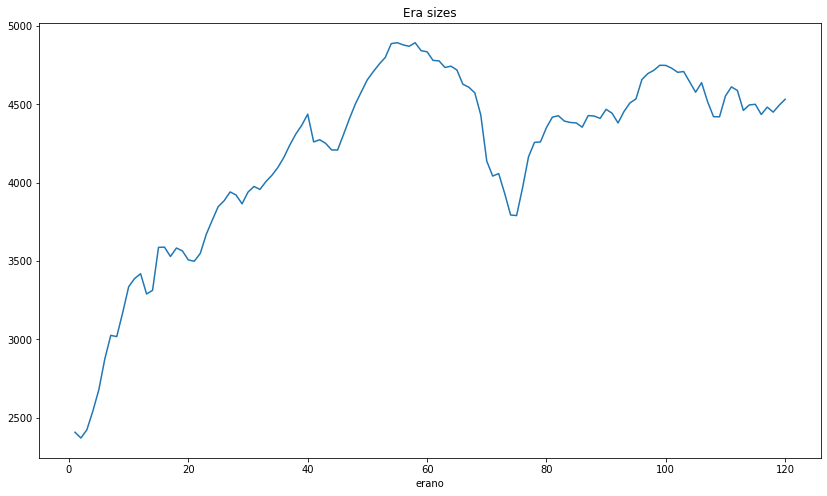

In [14]:
# Extract era numbers
trainingData["erano"] = trainingData.era.str.slice(3).astype(int)
plt.figure(figsize=[14, 6])
trainingData.groupby(trainingData['erano'])["target"].size().plot(title="Era sizes", figsize=(14, 8));

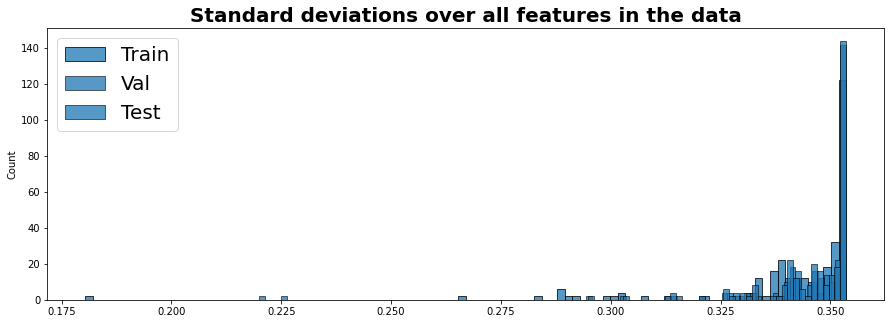

In [15]:
feats = [f for f in trainingData.columns if "feature" in f]
plt.figure(figsize=(15, 5))
sns.histplot(pd.DataFrame(trainingData[feats].std()), color='green',bins=100)
sns.histplot(pd.DataFrame(validationData[feats].std()), color='blue',bins=100)
sns.histplot(pd.DataFrame(testData[feats].std()), color='red', bins=100)
plt.legend(["Train", "Val", "Test"], fontsize=20)
plt.title("Standard deviations over all features in the data", weight='bold', fontsize=20);

# 5. Feature Engineering

In [16]:
# Calculate correlations with target
full_corr = trainingData.corr()
corr_with_target = full_corr["target"].T.apply(abs).sort_values(ascending=False)

# Select features with highest correlation to the target variable
features = corr_with_target[:150]
features.drop("target", inplace=True)

# Select Most Highly Correlated Features From Training Set
feature_list = features.index.tolist()
trainingDataEng = trainingData[feature_list]

print("Top 10 Features according to correlation with target:")
features[:10]

Top 10 Features according to correlation with target:


feature_strength34     0.012310
feature_dexterity7     0.012175
feature_dexterity6     0.011807
feature_dexterity4     0.011706
feature_strength14     0.011353
feature_charisma69     0.010858
feature_dexterity11    0.010820
feature_charisma37     0.010719
feature_charisma9      0.010683
feature_charisma19     0.010543
Name: target, dtype: float64

In [17]:
# Select Features From Training Data
trainingDataX = pd.get_dummies(trainingDataEng[trainingDataEng.columns[trainingDataEng.columns.str.startswith('feature')]])

# Select Targets From Training Data
trainingDataY = trainingData[trainingData.columns[trainingData.columns.str.startswith('target')]]

# Converrt to numpy arrays
trainingDataX = np.array(trainingDataX)
trainingDataY = np.array(trainingDataY)

In [18]:
# Split Up Data
xTrain, xTest, yTrain, yTest = train_test_split(trainingDataX, trainingDataY, test_size = 0.25)

# 6. Train Model

In [19]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, verbose=1, random_state=42, n_jobs=-2)

# Train the model on training data
rf.fit(xTrain, yTrain.flatten())

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done 178 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-2)]: Done 428 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-2)]: Done 778 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed: 58.7min finished


RandomForestRegressor(n_estimators=1000, n_jobs=-2, random_state=42, verbose=1)

# 7. Validation

In [23]:
validationDataX = validationData[feature_list]
validationDataX = pd.get_dummies(validationDataX[validationDataX.columns[validationDataX.columns.str.startswith('feature')]])

validationDataY = validationData[validationData.columns[validationData.columns.str.startswith('target')]]

In [24]:
predictions = rf.predict(validationDataX)

[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    3.1s
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed:    7.5s
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed:   13.5s
[Parallel(n_jobs=11)]: Done 1000 out of 1000 | elapsed:   17.2s finished


In [32]:
validationDataY.values.flatten()

array([0.25, 0.5 , 1.  , ..., 0.5 , 1.  , 0.5 ])

In [33]:
predictions

array([0.492  , 0.4715 , 0.56525, ..., 0.5105 , 0.47525, 0.5045 ])

# 8. Generate Predictions

In [29]:
# Performance metrics
errors = abs(predictions - validationDataY)
print('Metrics for Random Forest Trained on Expanded Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / test_labels))
# Compare to baseline
improvement_baseline = 100 * abs(mape - baseline_mape) / baseline_mape
print('Improvement over baseline:', round(improvement_baseline, 2), '%.')
# Calculate and display accuracy
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

ValueError: Unable to coerce to Series, length must be 1: given 137779

In [ ]:
# predictions must have an `id` column and a `prediction_kazutsugi` column
predictions_df = tournament_data["id"].to_frame()
predictions_df["prediction_kazutsugi"] = predictions
predictions_df.head()

In [ ]:
# Upload your predictions
predictions_df.to_csv("predictions.csv", index=False)
submission_id = napi.upload_predictions("predictions.csv", model_id=model_id)

# 9. Works Cited
- https://tit-btcqash.medium.com/a-comprehensive-guide-to-competing-at-numerai-70b356edbe07
- https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
- https://realpython.com/python-timer/
- https://www.kaggle.com/carlolepelaars/how-to-get-started-with-numerai
- https://medium.com/machine-learning-in-practice/cheat-sheet-of-machine-learning-and-python-and-math-cheat-sheets-a4afe4e791b6
- https://towardsdatascience.com/a-guide-to-the-hardest-data-science-tournament-on-the-planet-748f46e83690
- https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
- https://www.geeksforgeeks.org/python-flatten-a-2d-numpy-array-into-1d-array/
- https://docs.numer.ai/tournament/learn
- 